In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load diagnostics

In [7]:
import xarray as xr
import matplotlib.pyplot as plt

In [8]:
gridname = 'natv' #   choose from ['natv', 'rho2', 'zstr']
dt = 'monthly' #       choose from ['monthly', 'daily', 'hourly']

In [9]:
# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])

### Load budget metadata

In [13]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6").copy()

We load in the file `xbudget/conventions/MOM6.yaml`, which comprehensively details the mass, heat, and salt budgets in MOM6, and how they can be evaluated using various combinations of diagnostics.

In [14]:
import json
print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": "opottemptend",
            "advection": {
                "sum": {
                    "interfacial": {
                        "product": {
                            "convergence": "Th_tendency_vert_remap",
                            "sign": -1.0,
                            "var": null
                        },
                        "var": null
                    },
                    "lateral": {
                        "product": {
                            "convergence": "T_advection_xy",
                            "sign": -1.0,
                            "var": null
                        },
                        "var": null
                    },
                    "var": null
                },
                "var": null
            },
            "surface_ocean_flux_advective_negative_lhs": {
                "product": {
                    "density": 1035.0,
            

The `var: null` entries in the dictionary denote where diagnostics are not directly available. In many cases, however, they can be reconstructed by taking the sum or product of available diagnostics.

We can use the `xbudget.collect_budgets` function to leverage the information in this metadata dictionary to fill in all of these gaps in the budget.

In [15]:
xbudget.collect_budgets(ds, budgets_dict)

 All of these reconstructed budget terms are also automatically (and lazily) added to the original dataset with a straight-forward naming convention, so they can be used directly to evaluate the budget.

In [16]:
import json
print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": "opottemptend",
            "advection": {
                "sum": {
                    "interfacial": {
                        "product": {
                            "convergence": "Th_tendency_vert_remap",
                            "sign": -1.0,
                            "var": "heat_lhs_advection_interfacial_product"
                        },
                        "var": "heat_lhs_advection_interfacial_product"
                    },
                    "lateral": {
                        "product": {
                            "convergence": "T_advection_xy",
                            "sign": -1.0,
                            "var": "heat_lhs_advection_lateral_product"
                        },
                        "var": "heat_lhs_advection_lateral_product"
                    },
                    "var": "heat_lhs_advection_sum"
                },
                "var": "he

Because searching through this data structure by eye can be tedious, we include helpers functions to help retrieve the variable name corresponding to each term in the budget.

In [17]:
from xbudget import get_vars
get_vars(budgets_dict, "heat_lhs_advection")

'heat_lhs_advection_sum'

The `get_vars` functions takes either a string or a list of strings:

In [18]:
get_vars(budgets_dict, ["heat_lhs", "heat_rhs_diffusion", "heat_rhs_surface_exchange_flux"])

['heat_lhs_sum', 'heat_rhs_diffusion_sum', 'boundary_forcing_heat_tendency']

For variables that are the sum or product of other terms, it also returns a list of the variables that feed into the operation:

In [19]:
get_vars(budgets_dict, "heat_lhs_sum")

{'var': 'heat_lhs_sum',
 'sum': ['opottemptend',
  'heat_lhs_advection_sum',
  'heat_lhs_surface_ocean_flux_advective_negative_lhs_product']}

In [20]:
get_vars(budgets_dict, "heat_lhs_surface_ocean_flux_advective_negative_lhs_product")

{'var': 'heat_lhs_surface_ocean_flux_advective_negative_lhs_product',
 'product': [-1.0, 3992.0, 'tos', 'boundary_forcing_h_tendency', 1035.0]}

In [21]:
budgets_dict

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'transport': {'X': 'umo', 'Y': 'vmo'},
  'lhs': {'var': 'mass_lhs_sum',
   'sum': {'var': 'mass_lhs_sum',
    'Eulerian_tendency': {'var': 'mass_lhs_Eulerian_tendency_product',
     'product': {'var': 'mass_lhs_Eulerian_tendency_product',
      'thickness_tendency': 'dhdt',
      'density': 1035.0}}}},
  'rhs': {'var': 'mass_rhs_sum',
   'sum': {'var': 'mass_rhs_sum',
    'advection': {'var': 'mass_rhs_advection_sum',
     'sum': {'var': 'mass_rhs_advection_sum',
      'lateral': {'var': 'mass_rhs_advection_lateral_product',
       'product': {'var': 'mass_rhs_advection_lateral_product',
        'thickness_tendency': 'dynamics_h_tendency',
        'density': 1035.0}},
      'interfacial': {'var': 'mass_rhs_advection_interfacial_product',
       'product': {'var': 'mass_rhs_advection_interfacial_product',
        'thickness_tendency': 'vert_remap_h_tendency',
        'density': 1035.0}}}},
    'surface_exchange_flux': {'var': '

### Verification that the budgets close

We compare the left-hand-side (LHS) tendency terms against the sum of all of the right-hand-side (RHS) terms. 

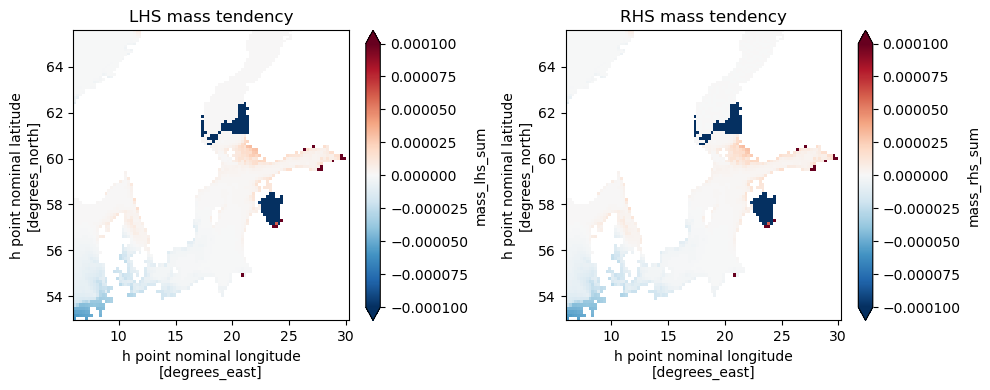

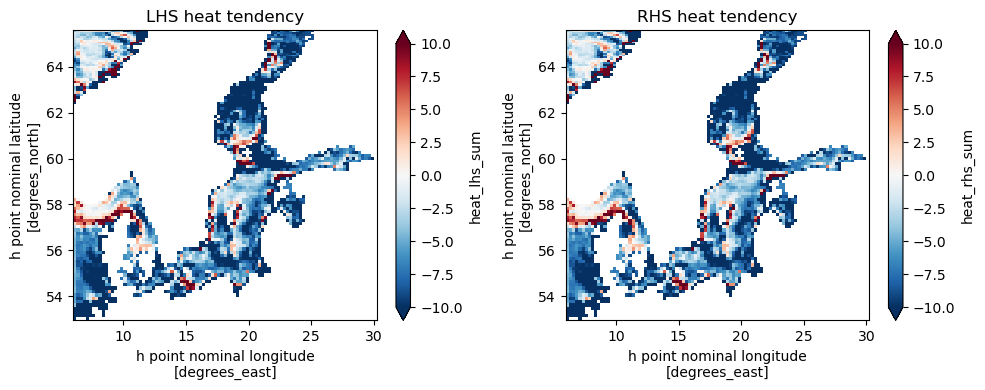

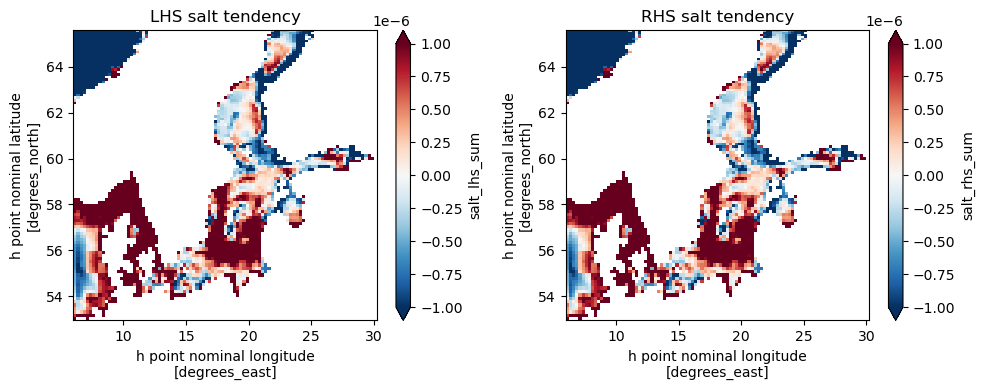

In [22]:
for eq, vmax in zip(["mass", "heat", "salt"], [1.e-4, 10, 1.e-6]):
    plt.figure(figsize=(10, 4))

    plt.subplot(1,2,1)
    ds[get_vars(budgets_dict, f"{eq}_lhs")].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    plt.title(f"LHS {eq} tendency")
    
    plt.subplot(1,2,2)
    ds[get_vars(budgets_dict, f"{eq}_rhs")].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    plt.title(f"RHS {eq} tendency")

    plt.tight_layout()

### Decompose RHS budget terms with `xbudget`

Since the full budget is relatively clunky and can be decomposed in a number of different ways, we include helper functions for collecting all of the high-level terms and optionally dissaggreating terms of interest:

In [23]:
# Default high-level aggregate budget
simple_budgets = xbudget.aggregate(budgets_dict)
simple_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'transport': {'X': 'umo', 'Y': 'vmo'},
  'lhs': {'Eulerian_tendency': 'mass_lhs_Eulerian_tendency_product'},
  'rhs': {'advection': 'mass_rhs_advection_sum',
   'surface_exchange_flux': 'mass_rhs_surface_exchange_flux_product'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'opottemptend',
   'advection': 'heat_lhs_advection_sum',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_surface_ocean_flux_advective_negative_lhs_product'},
  'rhs': {'diffusion': 'heat_rhs_diffusion_sum',
   'surface_exchange_flux': 'boundary_forcing_heat_tendency',
   'surface_ocean_flux_advective_negative_rhs': 'heat_rhs_surface_ocean_flux_advective_negative_rhs_product',
   'bottom_flux': 'internal_heat_heat_tendency',
   'frazil_ice': 'frazil_heat_tendency'}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'lhs': {'Eulerian_tendency': 'osalttend',
   'advection': 'salt_lhs_advection_sum',
 

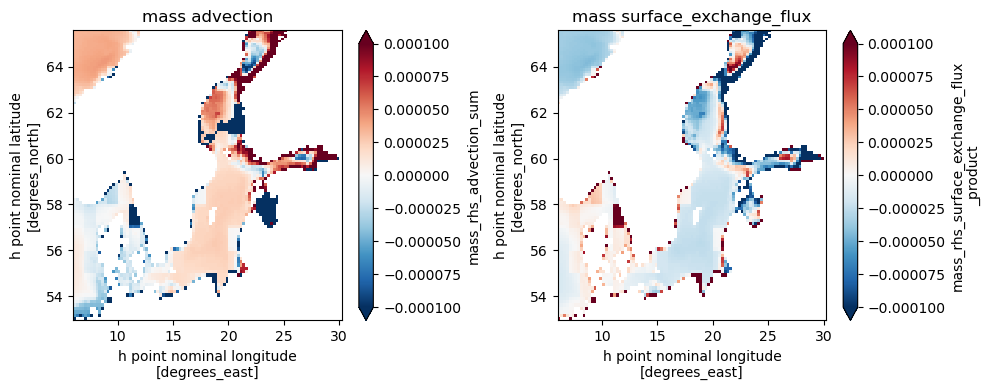

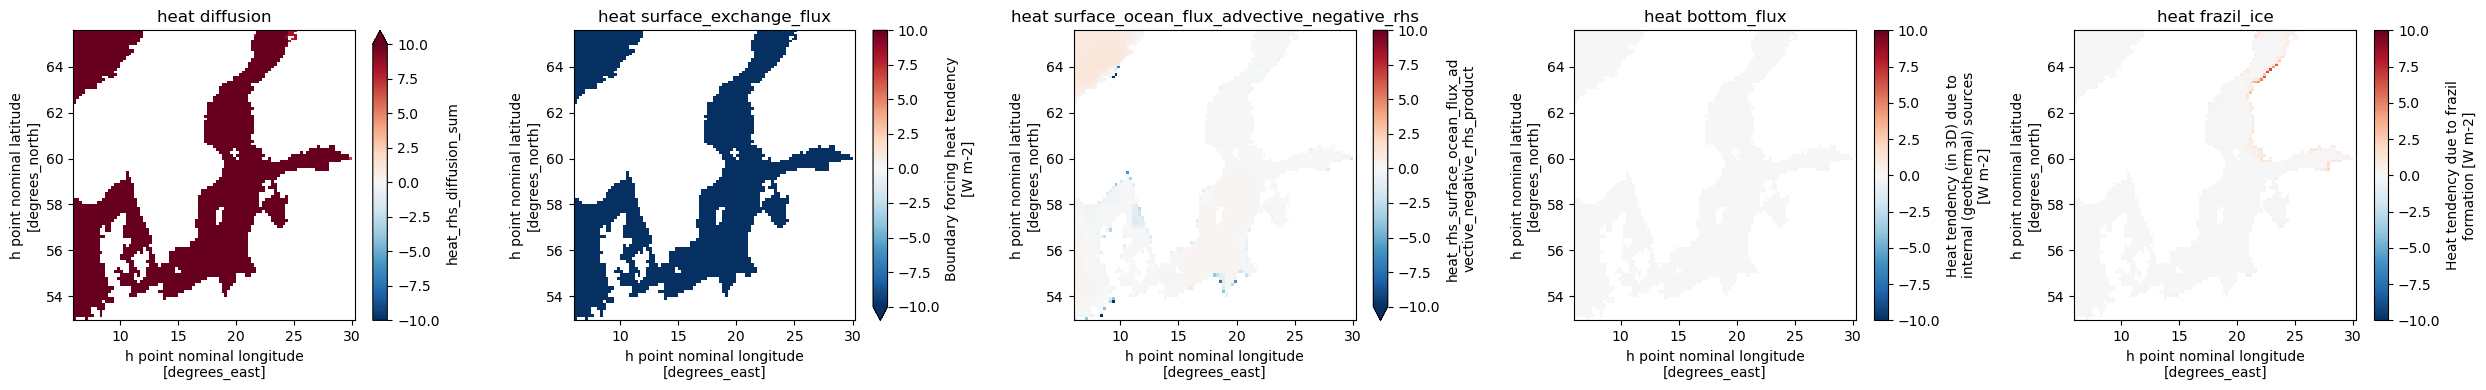

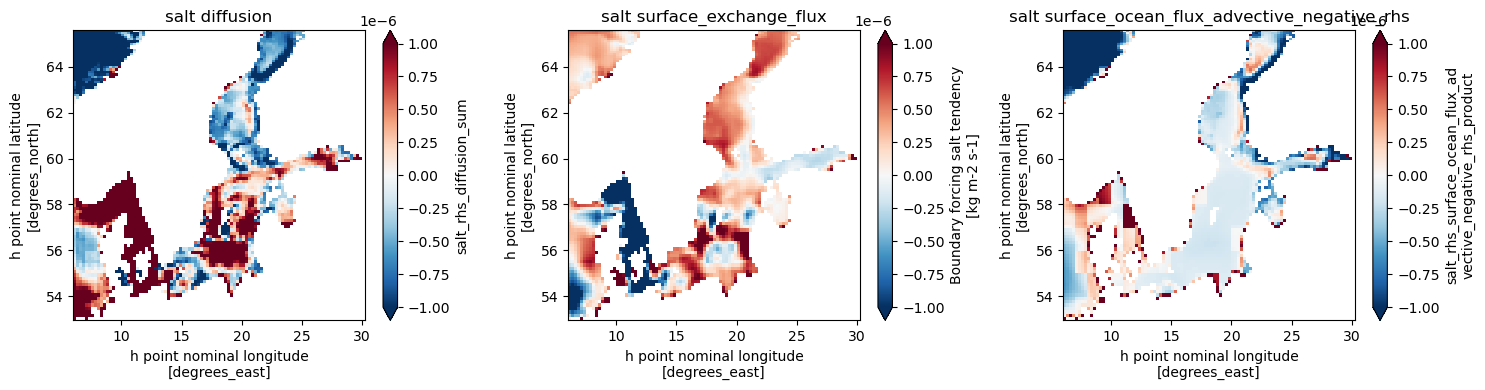

In [24]:
vmax = 1.e-4

for eq, vmax in zip(["mass", "heat", "salt"], [1.e-4, 10, 1.e-6]):
    N = len(simple_budgets[eq]['rhs'])
    plt.figure(figsize=(5*N, 4))
    for i, (k,v) in enumerate(simple_budgets[eq]['rhs'].items(), start=1):
        plt.subplot(1,N, i)
        if "zl" in ds[v].dims:
            ds[v].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        else:
            ds[v].isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        plt.title(f"{eq} {k}")

    plt.tight_layout()

### Custom budget decompositions

Suppose we want to have a better understanding of the processes driving both the `surface_flux` terms and interior `diffusion` terms. We can simply pass the list of these process names to the `decompose` keyword argument. We can also further breakdown the `nonadvective` part of the `surface_flux` term.

In [25]:
decomposed_budgets = xbudget.aggregate(budgets_dict, decompose=["surface_exchange_flux", "nonadvective", "diffusion"])
decomposed_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'transport': {'X': 'umo', 'Y': 'vmo'},
  'lhs': {'Eulerian_tendency': 'mass_lhs_Eulerian_tendency_product'},
  'rhs': {'advection': 'mass_rhs_advection_sum',
   'surface_exchange_flux_rain_and_ice': 'prlq',
   'surface_exchange_flux_snow': 'prsn',
   'surface_exchange_flux_evaporation': 'evs',
   'surface_exchange_flux_rivers': 'friver',
   'surface_exchange_flux_icebergs': 'ficeberg',
   'surface_exchange_flux_virtual_precip_restoring': 'vprec'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'opottemptend',
   'advection': 'heat_lhs_advection_sum',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_surface_ocean_flux_advective_negative_lhs_product'},
  'rhs': {'diffusion_lateral': 'opottemppmdiff',
   'diffusion_interfacial': 'opottempdiff',
   'surface_exchange_flux_nonadvective_latent': 'hflso',
   'surface_exchange_flux_nonadvective_sensible': 'hfsso',
   'surface_exchange_

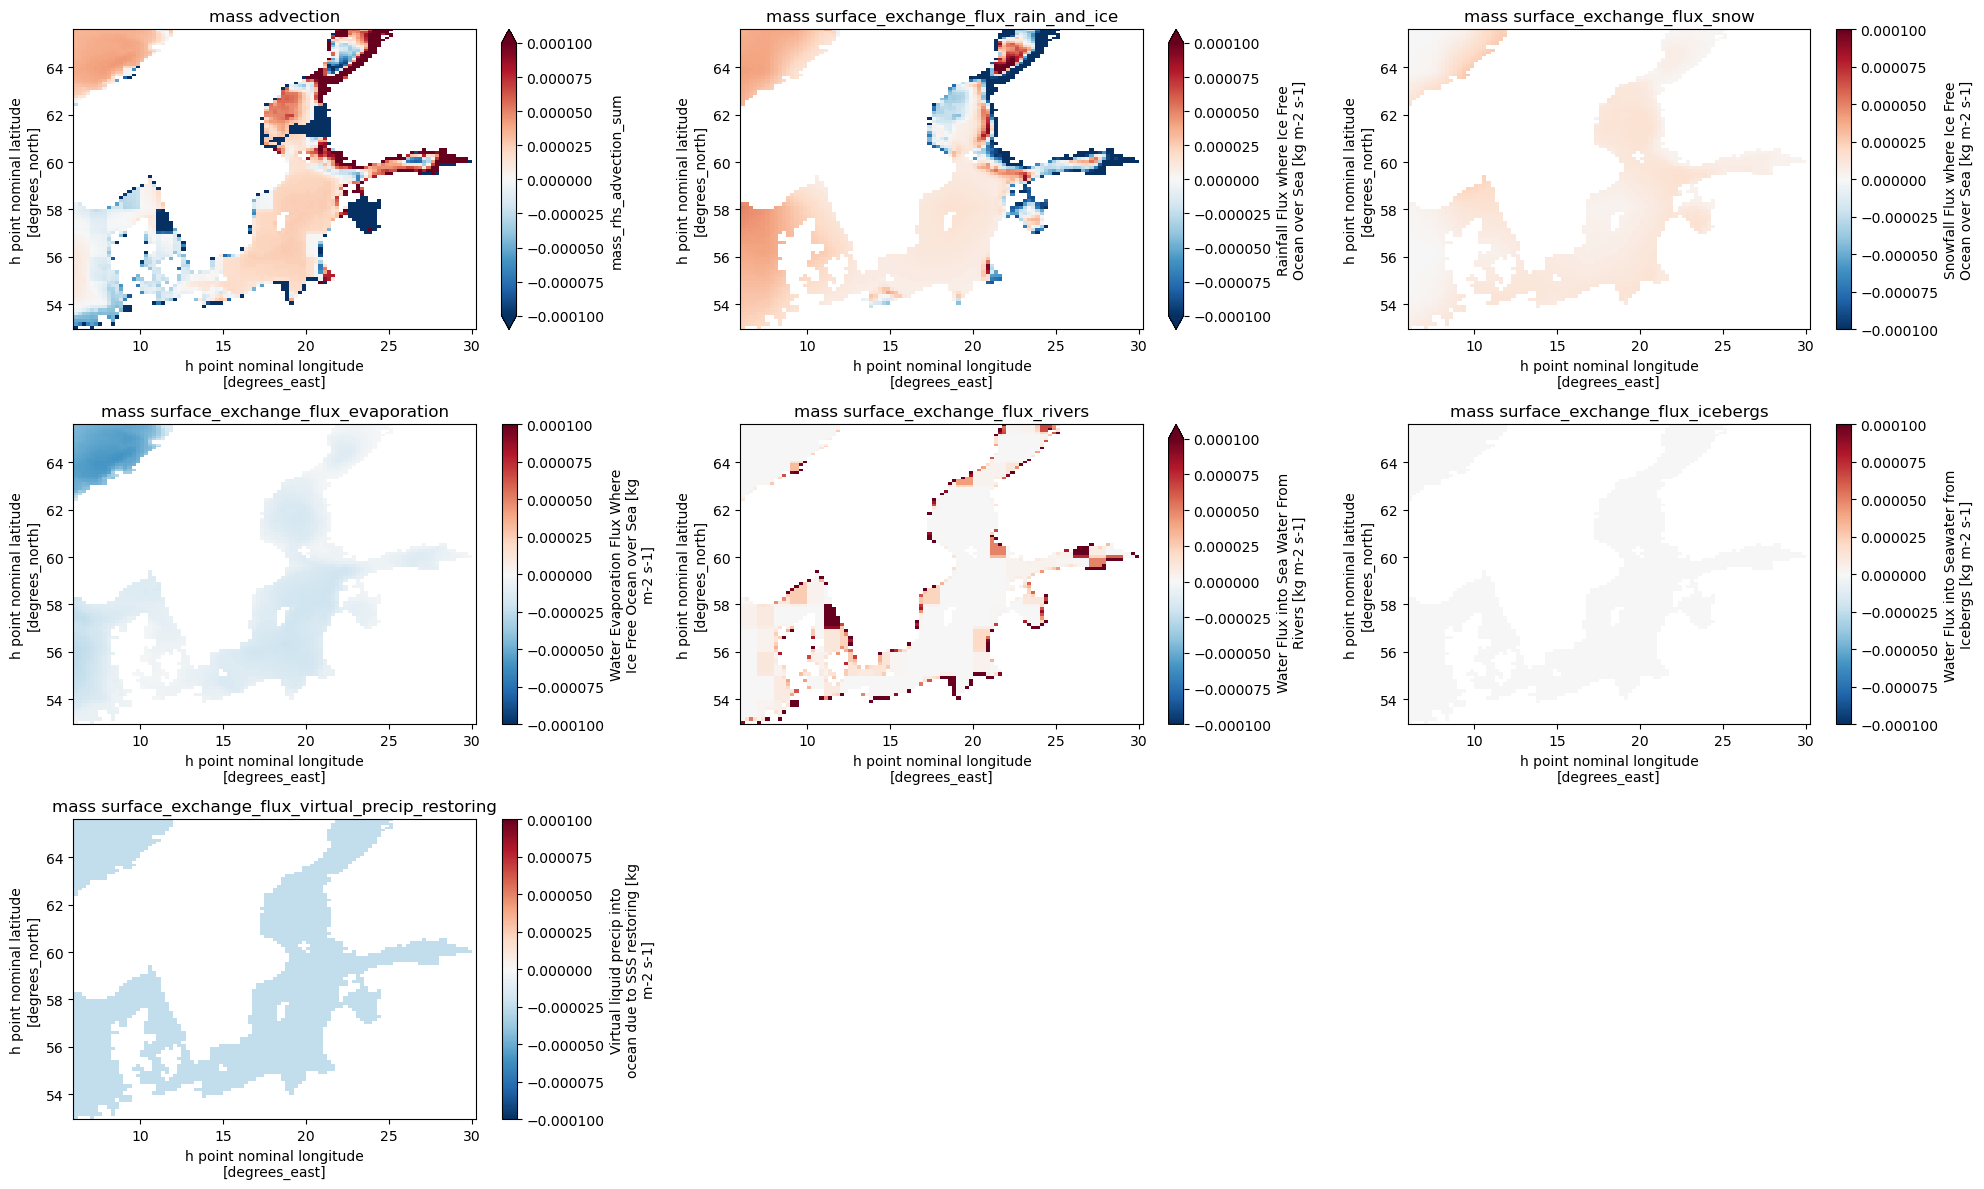

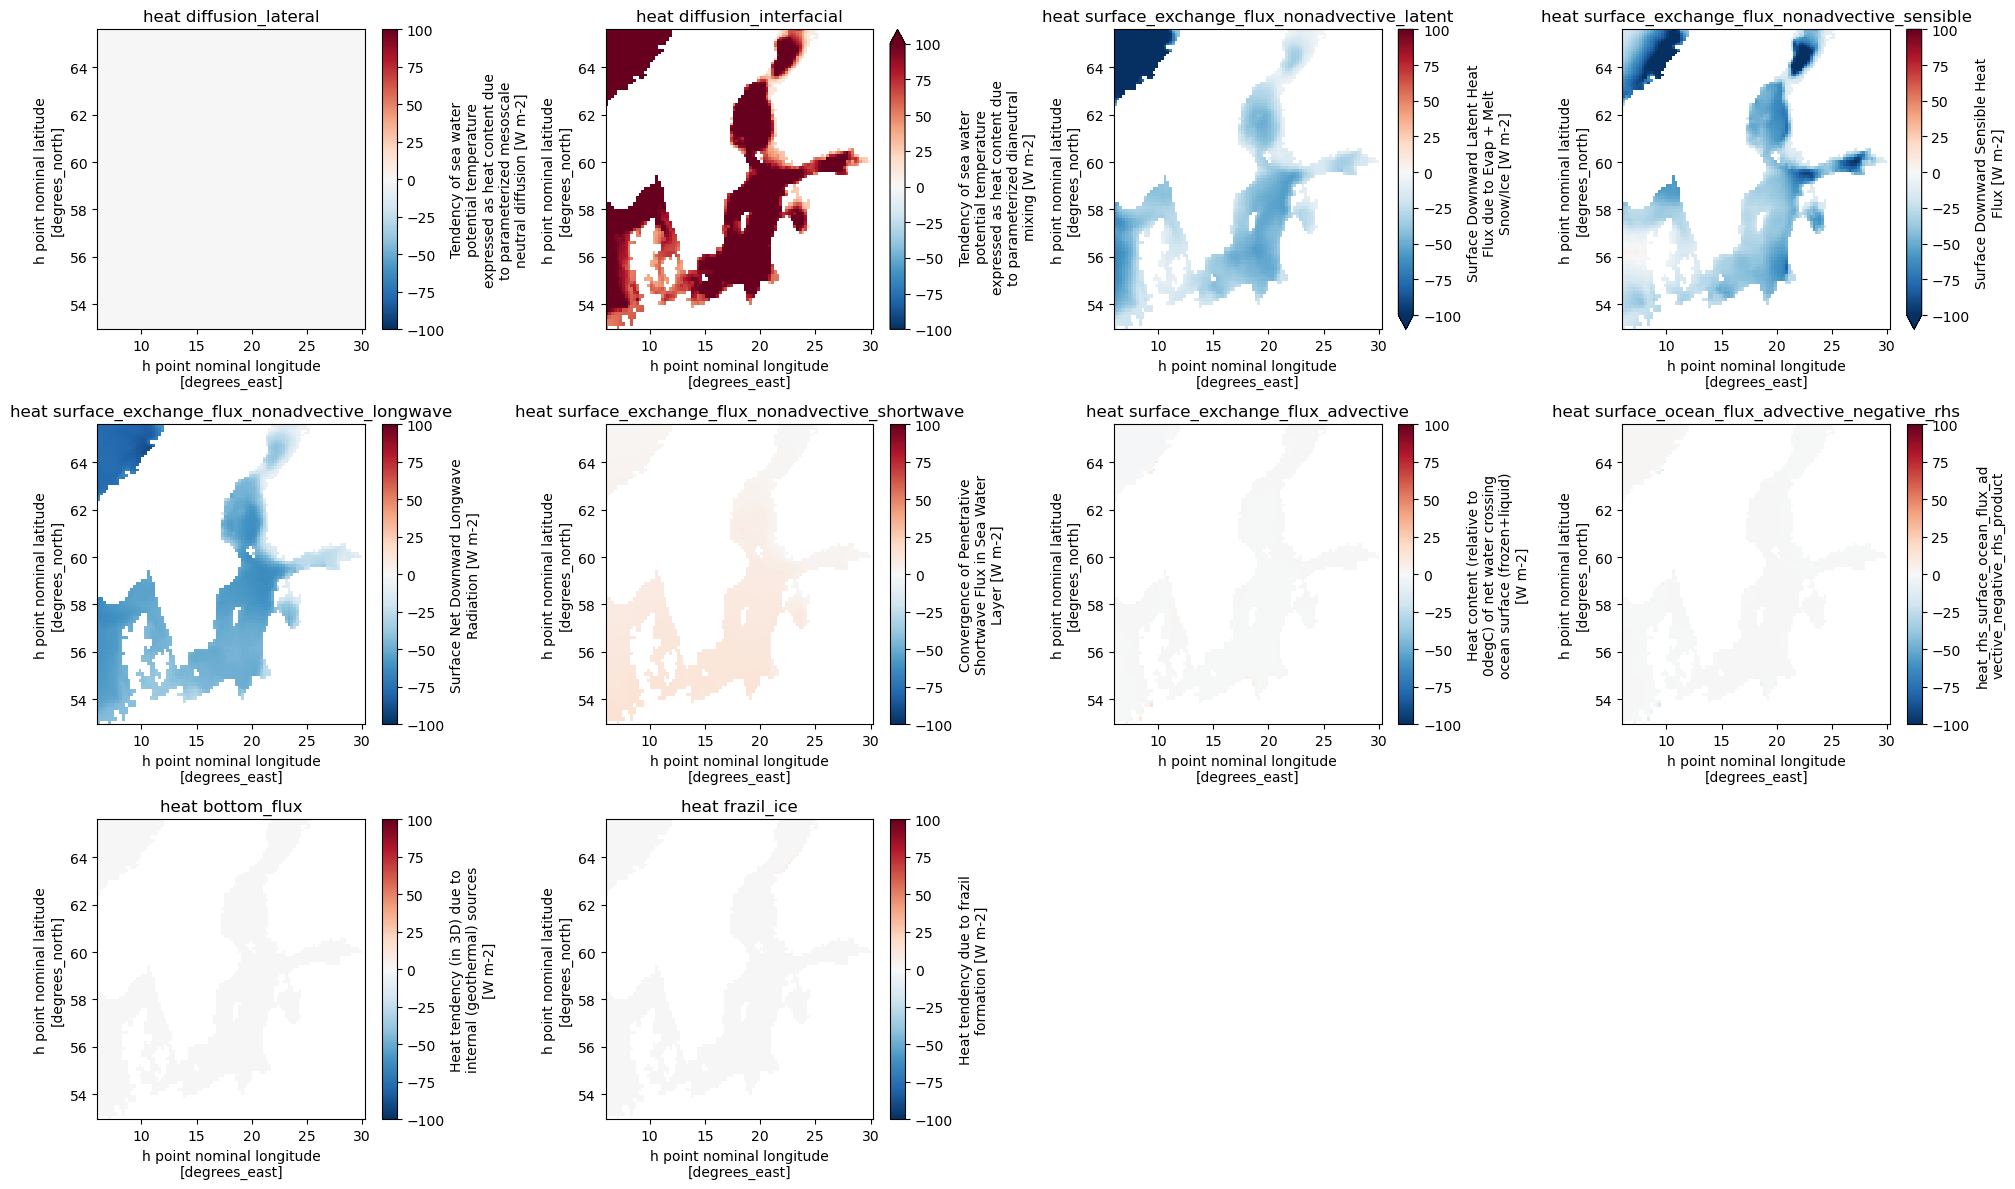

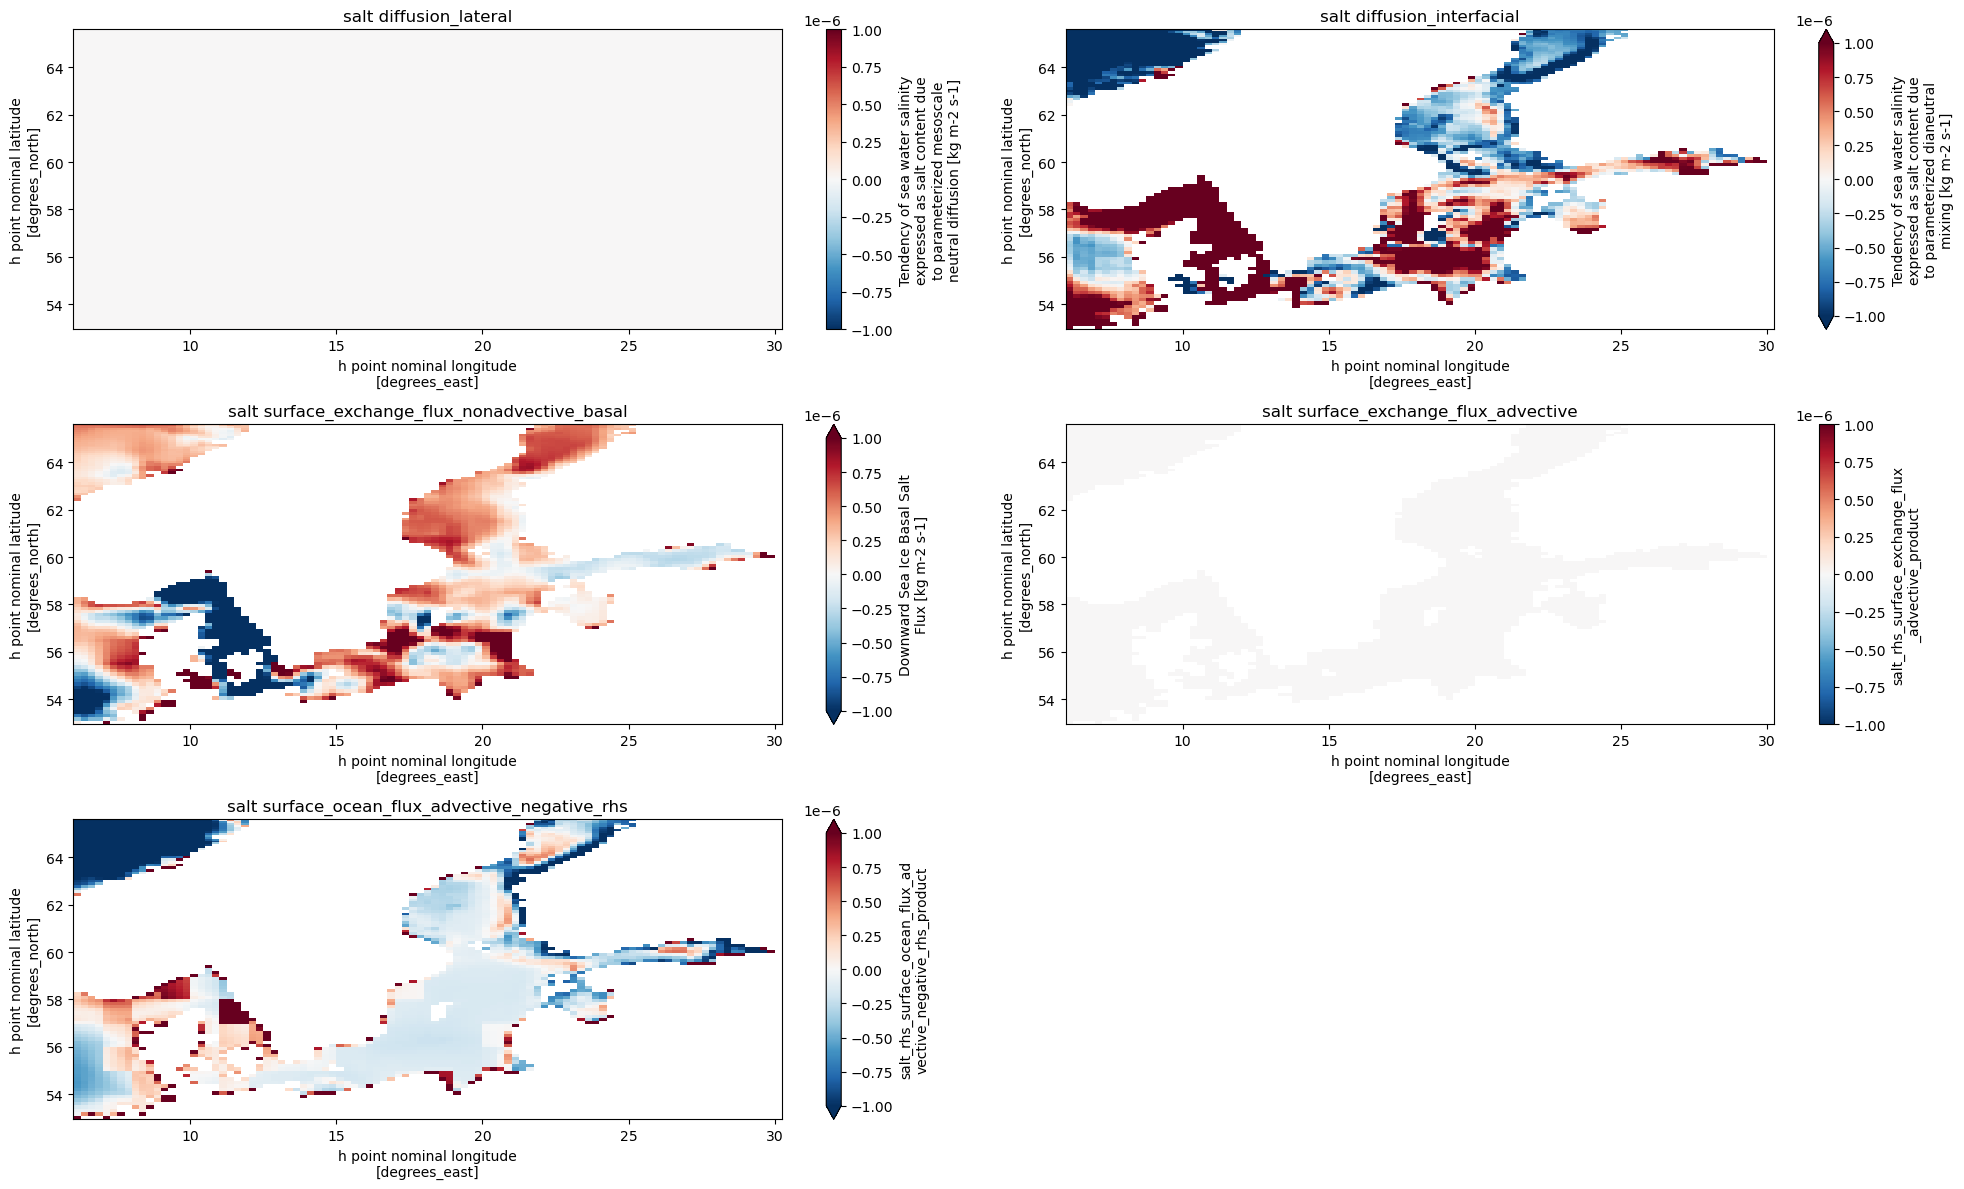

In [26]:
vmax = 1.e-4
import numpy as np

for eq, vmax in zip(["mass", "heat", "salt"], [1.e-4, 100, 1.e-6]):
    plt.figure(figsize=(20, 12))
    for i, (k,v) in enumerate(decomposed_budgets[eq]['rhs'].items(), start=1):
        plt.subplot(3, np.int64(np.ceil(len(decomposed_budgets[eq]['rhs'])/3)), i)
        if "zl" in ds[v].dims:
            ds[v].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        else:
            ds[v].isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        plt.title(f"{eq} {k}")

    plt.tight_layout()